In [1]:
import os
import glob
import json
import random
from pathlib import Path
from difflib import SequenceMatcher


import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sroie_folder_path = Path('/content/drive/MyDrive/Dissertation/SROIE2019')
example_file = 'X51005365187.txt'

In [4]:
example_file

'X51005365187.txt'

In [5]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore') as f:
    for line in f.read().splitlines():
      if len(line) == 0:
        continue

      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # From the splited line we save (filename, [bounding box points], text line).
      # The filename will be useful in the future
      bbox_and_words_list.append([path.stem, *bbox, text])

  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'])
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe


# Example usage
bbox_file_path = sroie_folder_path / "test/box" / example_file
print("== File content ==")
!head -n 5 "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Dataframe ==")
bbox.head(5)

== File content ==
17,35,371,35,371,91,17,91,3-1707067
222,115,511,115,511,143,222,143,F&P PHARMACY
274,148,457,148,457,174,274,174,(002309592-P)
204,183,529,183,529,210,204,210,NO.20. GROUND FLOOR,
99,218,632,218,632,244,99,244,JALAN BS 10/6 TAMAN BUKIT SERDANG,

== Dataframe ==


,filename,x0,y0,x2,y2,line
0,X51005365187,17,35,371,91,3-1707067
1,X51005365187,222,115,511,143,F&P PHARMACY
2,X51005365187,274,148,457,174,(002309592-P)
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,"
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,"


In [6]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe

In [7]:
entities_file_path = sroie_folder_path /  "test/entities" / example_file
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "F&P PHARMACY",
    "date": "02/03/2018",
    "address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
    "total": "31.90"
}

== Dataframe ==


,company,date,address,total
0,F&P PHARMACY,02/03/2018,"NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT...",31.90


In [8]:
from difflib import SequenceMatcher

def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    best_match_score = 0
    best_match_label = "O"

    for column in entities.columns:
        entity_values = entities[column].iloc[0].replace(",", "").strip()
        entity_set = entity_values.split()

        matches_count = sum(1 for l in line_set if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set))
        similarity_score = matches_count / len(line_set)

        if (column.upper() == 'ADDRESS' and similarity_score >= 0.5) or \
           (column.upper() != 'ADDRESS' and similarity_score == 1):
            return column.upper()

        if matches_count > 0 and similarity_score > best_match_score:
            best_match_score = similarity_score
            best_match_label = column.upper()

    return best_match_label

line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)


Line: F&P PHARMACY
Assigned label: COMPANY


In [9]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(50)

,filename,x0,y0,x2,y2,line,label
0,X51005365187,17,35,371,91,3-1707067,O
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY
2,X51005365187,274,148,457,174,(002309592-P),O
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,",ADDRESS
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,",ADDRESS
5,X51005365187,111,250,623,275,"SEKSYEN 10, 43300 SERI KEMBANGAN,",ADDRESS
6,X51005365187,186,284,538,308,SELANGOR DARUL EHSAN,ADDRESS
7,X51005365187,251,316,484,339,TEL 03-89599823,O
8,X51005365187,182,351,346,378,GST REG NO,O
9,X51005365187,274,387,461,409,TAX INVOICE,O


In [10]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0


  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0'] = x0
    line_copy.at['x2'] = x2
    line_copy.at['line'] = word
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)


Original row:


,filename,x0,y0,x2,y2,line,label
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005365187,222,115,294,143,F&P,COMPANY
1,X51005365187,299,115,491,143,PHARMACY,COMPANY


In [11]:
def dataset_creator(folder: Path):
    bbox_folder = folder / 'box'
    entities_folder = folder / 'entities'
    img_folder = folder / 'img'

    entities_files = sorted(entities_folder.glob("*.txt"))
    bbox_files = sorted(bbox_folder.glob("*.txt"))
    img_files = sorted(img_folder.glob("*.jpg"))

    data = []

    print("Reading dataset:")
    for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):
        # Read the files
        bbox = read_bbox_and_words(bbox_file)
        entities = read_entities(entities_file)
        image = Image.open(img_file)

        # Assign labels to lines in bbox using entities
        bbox_labeled = assign_labels(bbox, entities)

        width, height = image.size

        data.append([bbox_labeled, width, height])

    return data


In [ ]:
# def dataset_creator(folder: Path):
#     bbox_folder = folder / 'box'
#     entities_folder = folder / 'entities'
#     img_folder = folder / 'img'

#     entities_files = sorted(entities_folder.glob("*.txt"))
#     bbox_files = sorted(bbox_folder.glob("*.txt"))
#     img_files = sorted(img_folder.glob("*.jpg"))

#     data = []

#     print("Reading dataset:")
#     for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):
#         # Read the files
#         bbox = read_bbox_and_words(bbox_file)
#         entities = read_entities(entities_file)
#         image = Image.open(img_file)

#         # Assign labels to lines in bbox using entities
#         bbox_labeled = assign_labels(bbox, entities)

#         # Split lines into separate tokens
#         new_bbox_l = []
#         for index, row in bbox_labeled.iterrows():
#             new_bbox_l += split_line(row)
#         new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns)

#         # Further refine labeling for increased precision
#         for index, row in new_bbox.iterrows():
#             label = row['label']

#             if label != "O":
#                 entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
#                 entity_set = entity_values.split()

#                 # Check similarity with entity set, if high, label as entity, otherwise 'O'
#                 if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
#                     label = "S-" + label  # Prefix 'S-' denotes a specific entity
#                 else:
#                     label = "O"

#             new_bbox.at[index, 'label'] = label

#         width, height = image.size

#         data.append([new_bbox, width, height])

#     return data

In [12]:
dataset_train = dataset_creator(sroie_folder_path / 'train')

Reading dataset:


100%|██████████| 626/626 [08:13<00:00,  1.27it/s]


In [13]:
dataset_test = dataset_creator(sroie_folder_path / 'test')

Reading dataset:


100%|██████████| 347/347 [04:19<00:00,  1.34it/s]


In [14]:
print(dataset_test[5])

[        filename   x0    y0   x2    y2  \
0   X51005230621  166   329  409   355   
1   X51005230621  179   358  333   382   
2   X51005230621  170   404  410   426   
3   X51005230621  181   431  396   455   
4   X51005230621  140   463  442   485   
5   X51005230621  140   493  437   515   
6   X51005230621   42   525  497   545   
7   X51005230621  128   556  448   582   
8   X51005230621  146   589  437   617   
9   X51005230621  210   641  348   661   
10  X51005230621   44   706  234   727   
11  X51005230621   41   748  164   771   
12  X51005230621  213   746  329   769   
13  X51005230621   44   778  106   801   
14  X51005230621  215   780  339   801   
15  X51005230621   41   810  148   833   
16  X51005230621  211   812  223   834   
17  X51005230621  297   859  334   880   
18  X51005230621  436   858  495   881   
19  X51005230621   42   896  241   920   
20  X51005230621  287   933  342   956   
21  X51005230621  475   935  507   956   
22  X51005230621   56   967  147 

In [15]:
print(dataset_train[3])

[        filename   x0   y0   x2   y2                                line  \
0   X00016469622   96   41  353   79                       TAN WOON YANN   
1   X00016469622   88  107  366  133                 YONGFATT ENTERPRISE   
2   X00016469622  171  137  280  155                         (JM0517726)   
3   X00016469622  104  162  347  179           NO 122.124 JALAN DEDAP 13   
4   X00016469622  136  184  316  198                   81100 JOHOR BAHRU   
5   X00016469622  157  220  295  238                      TEL 07-3523888   
6   X00016469622  135  252  320  269                GST ID: 000849813504   
7   X00016469622  112  277  349  296              SIMPLIFIED TAX INVOICE   
8   X00016469622   18  316   66  333                                CASH   
9   X00016469622   19  343   78  360                              DOC NO   
10  X00016469622  141  337  251  358                          CS00031663   
11  X00016469622  276  341  312  359                                DATE   
12  X000164

In [16]:
import os
import pandas as pd

# Path to the entities folder
entities_folder = "/content/drive/MyDrive/Dissertation/SROIE2019/train/entities"

# Function to read company values from JSON files
def read_company_values(folder):
    company_values = []
    for file_name in os.listdir(folder):
        if file_name.endswith(".txt"):
            with open(os.path.join(folder, file_name), "r") as file:
                data = json.load(file)
                company_value = data.get("company")
                if company_value:
                    company_values.append(company_value)
    return company_values

# Read company values from JSON files
company_values = read_company_values(entities_folder)

# Create DataFrame
company_df = pd.DataFrame({"company": company_values})

# Display DataFrame
print(company_df)


                                      company
0                    SHELL ISNI PETRO TRADING
1                              ABC HO TRADING
2                   LIGHTROOM GALLERY SDN BHD
3                   LIGHTROOM GALLERY SDN BHD
4                       MR D.I.Y. (M) SDN BHD
..                                        ...
621                     KEDAI PAPAN YEW CHUAN
622  ONE ONE THREE SEAFOOD RESTAURANT SDN BHD
623              LIAN HING STATIONERY SDN BHD
624                     KEDAI PAPAN YEW CHUAN
625                     KEDAI PAPAN YEW CHUAN

[626 rows x 1 columns]


In [17]:
num_unique_companies = company_df['company'].nunique()
print("Number of unique companies:", num_unique_companies)

Number of unique companies: 236


Number of unique companies: 236
Top 10 companies:
company
GARDENIA BAKERIES (KL) SDN BHD                       45
UNIHAKKA INTERNATIONAL SDN BHD                       42
SANYU STATIONERY SHOP                                36
99 SPEED MART S/B                                    31
MR. D.I.Y. (M) SDN BHD                               29
RESTORAN WAN SHENG                                   26
SYARIKAT PERNIAGAAN GIN KEE                          22
AEON CO. (M) BHD                                     15
ONE ONE THREE SEAFOOD RESTAURANT SDN BHD             12
AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD    12
Name: count, dtype: int64
Number of missing values in company column: 0


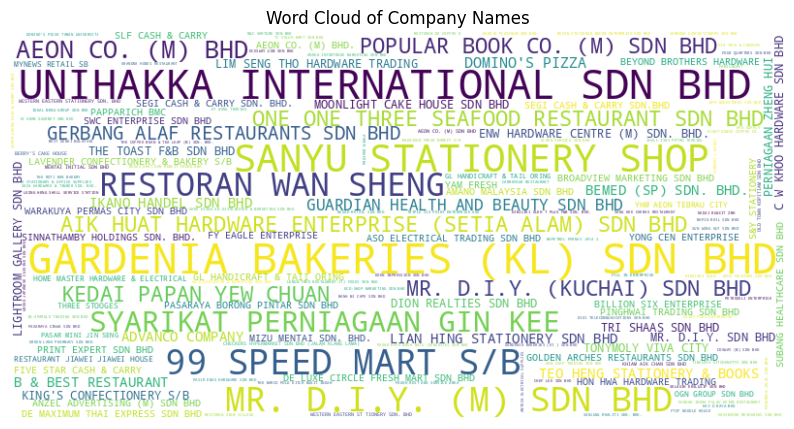

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming company_df contains the DataFrame with the 'company' column

# Basic statistics
num_unique_companies = company_df['company'].nunique()
company_counts = company_df['company'].value_counts()

print("Number of unique companies:", num_unique_companies)
print("Top 10 companies:")
print(company_counts.head(10))

# Data cleaning
# Check for missing values
missing_values = company_df['company'].isnull().sum()
print("Number of missing values in company column:", missing_values)

# # Visualization
# # Plot histogram of company name frequencies
# plt.figure(figsize=(10, 6))
# company_counts.plot(kind='bar', color='skyblue')
# plt.title('Company Name Frequencies')
# plt.xlabel('Company Name')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.show()

# Generate word cloud of company names
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(company_counts)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Company Names')
plt.show()


In [ ]:
# from google.colab.patches import cv2_imshow
# import cv2

# # Load bounding box coordinates
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X00016469620.txt', 'r') as f:
#     lines = f.readlines()

# # Load receipt image
# img = cv2.imread('/content/drive/MyDrive/Dissertation/SROIE2019/train/img/X00016469620.jpg')

# if img is None:
#     print("Error: Unable to load the image.")
# else:
#     # Draw bounding boxes
#     for line in lines:
#         coords = [int(coord) for coord in line.split(',')[:8]]  # Extracting only the coordinates
#         cv2.rectangle(img, (coords[0], coords[1]), (coords[4], coords[5]), (0, 255, 0), 2)

#     # Display the image with bounding boxes
#     cv2_imshow(img)

In [ ]:
# from google.colab.patches import cv2_imshow
# import cv2
# import json
# import re

# # Load bounding box coordinates
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X00016469612.txt', 'r') as f:
#     box_lines = f.readlines()

# # Load entities from JSON file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X00016469612.txt', 'r') as f:
#     entities_data = json.load(f)

# # Load receipt image
# img = cv2.imread('/content/drive/MyDrive/Dissertation/SROIE2019/train/img/X00016469612.jpg')

# if img is None:
#     print("Error: Unable to load the image.")
# else:
#     # Define color for the "company" entity
#     company_color = (255, 0, 0)  # Blue
#     # Define color for other entities
#     other_color = (192, 192, 192)  # Grey

#     # Extract the company value from the entities data
#     company_value = entities_data['company']

#     # Function to check if a box contains or exactly matches the company value
#     def is_company(text):
#         return text.strip().lower() == company_value.lower() or company_value.lower() in text.strip().lower()

#     # Function to draw bounding boxes
#     def draw_boxes(color):
#         for line in box_lines:
#             line_parts = line.strip().split(',')
#             if len(line_parts) >= 8:
#                 coords = [int(coord) for coord in line_parts[:8]]  # Extract coordinates
#                 box_text = ','.join(line_parts[8:])  # Extract text

#                 # Check if the box text matches the company value
#                 if is_company(box_text):
#                     for i in range(0, 7, 2):
#                         cv2.line(img, (coords[i], coords[i+1]), (coords[(i+2)%8], coords[(i+3)%8]), color, 2)
#                     cv2.line(img, (coords[0], coords[1]), (coords[6], coords[7]), color, 2)
#                 else:
#                     for i in range(0, 7, 2):
#                         cv2.line(img, (coords[i], coords[i+1]), (coords[(i+2)%8], coords[(i+3)%8]), other_color, 2)
#                     cv2.line(img, (coords[0], coords[1]), (coords[6], coords[7]), other_color, 2)

#     # Draw bounding boxes
#     draw_boxes(company_color)

#     # Display the image with colored bounding boxes
#     cv2_imshow(img)


In [ ]:
# import json

# # Load entities from JSON file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X00016469612.txt', 'r') as f:
#     entities_data = json.load(f)

# # Extract company, address, date, and total text
# company_text = entities_data.get("company", "").strip("'")
# address_text = entities_data.get("address", "").strip("'")
# date_text = entities_data.get("date", "").strip("'")
# total_text = entities_data.get("total", "").strip("'")

# # Display the extracted texts
# print("Company Text:", company_text)
# print("Address Text:", address_text)


In [ ]:
# import json

# # Load entities from JSON file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X00016469612.txt', 'r') as f:
#     entities_data = json.load(f)

# # Extract company and address text from entities data
# company_text = entities_data.get("company", "").strip("'")  # Remove single quotes
# address_text = entities_data.get("address", "").strip("'")  # Remove single quotes

# # Define variables to store company and address coordinates
# company_coordinates = None
# address_coordinates = []

# # Loop through the lines in the box file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X00016469612.txt', 'r') as f:
#     box_lines = f.readlines()

# for line in box_lines:
#     # Extract coordinates and text from the line
#     parts = line.strip().split(',')
#     coordinates = list(map(int, parts[:8]))  # Extract coordinates
#     text = ",".join(parts[8:]).strip("'")  # Join the remaining parts as text and remove single quotes

#     # Check if the text matches the company or address
#     if text == company_text:
#         company_coordinates = coordinates
#     elif text == address_text:
#         address_coordinates.append(coordinates)

# # Display the coordinates
# print("Company Coordinates:", company_coordinates)
# print("Address Coordinates:", address_coordinates)


In [ ]:
# import json

# # Load entities from JSON file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X00016469612.txt', 'r') as f:
#     entities_data = json.load(f)

# # Extract company and address text from entities data
# company_text = entities_data.get("company", "").strip("'")  # Remove single quotes
# address_text = entities_data.get("address", "").strip("'")  # Remove single quotes

# # Print the extracted texts
# print("Extracted Company Text:", company_text)
# print("Extracted Address Text:", address_text)

# # Define variables to store company and address coordinates
# company_coordinates = None
# address_coordinates = []

# # Loop through the lines in the box file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X00016469612.txt', 'r') as f:
#     box_lines = f.readlines()

# for line in box_lines:
#     # Extract coordinates and text from the line
#     parts = line.strip().split(',')
#     coordinates = list(map(int, parts[:8]))  # Extract coordinates
#     text = ",".join(parts[8:]).strip("'")  # Join the remaining parts as text and remove single quotes

#     # Check if the text matches the company or address
#     if text == company_text:
#         company_coordinates = coordinates
#     elif text == address_text:
#         address_coordinates.append(coordinates)

# # Display the coordinates
# print("Company Coordinates:", company_coordinates)
# print("Address Coordinates:", address_coordinates)


In [ ]:
# import json

# # Load entities from JSON file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X00016469612.txt', 'r') as f:
#     entities_data = json.load(f)

# # Extract company and address text from entities data
# company_text = entities_data.get("company", "").strip("'")  # Remove single quotes
# address_text = entities_data.get("address", "").strip("'")  # Remove single quotes

# # Print the extracted texts
# print("Extracted Company Text:", company_text)
# print("Extracted Address Text:", address_text)

# # Define variables to store company and address coordinates
# company_coordinates = None
# address_coordinates = []

# # Loop through the lines in the box file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X00016469612.txt', 'r') as f:
#     box_lines = f.readlines()

# for line in box_lines:
#     # Extract coordinates and text from the line
#     parts = line.strip().split(',')
#     coordinates = list(map(int, parts[:8]))  # Extract coordinates
#     text = ",".join(parts[8:]).strip("'")  # Join the remaining parts as text and remove single quotes

#     # Print the line and text for debugging
#     print("Line:", line.strip())
#     print("Text:", text)

#     # Check if the text matches the company or address
#     if text == company_text:
#         company_coordinates = coordinates
#     elif text == address_text:
#         address_coordinates.append(coordinates)

# # Display the coordinates
# print("Company Coordinates:", company_coordinates)
# print("Address Coordinates:", address_coordinates)


In [ ]:
# import json
# from fuzzywuzzy import fuzz

# # Load entities from JSON file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X00016469612.txt', 'r') as f:
#     entities_data = json.load(f)

# # Extract company, address, date, and total text from entities data
# company_text = entities_data.get("company", "").strip("'")  # Remove single quotes
# address_text = entities_data.get("address", "").strip("'")  # Remove single quotes
# date_text = entities_data.get("date", "").strip("'")  # Remove single quotes
# total_text = entities_data.get("total", "").strip("'")  # Remove single quotes

# # Print the extracted texts
# print("Extracted Company Text:", company_text)
# print("Extracted Address Text:", address_text)
# print("Extracted Date Text:", date_text)
# print("Extracted Total Text:", total_text)

# # Define variables to store company, address, date, and total coordinates
# company_coordinates = []
# address_coordinates = []
# date_coordinates = []
# total_coordinates = []

# # Loop through the lines in the box file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X00016469612.txt', 'r') as f:
#     box_lines = f.readlines()

# for line in box_lines:
#     # Extract coordinates and text from the line
#     parts = line.strip().split(',')
#     coordinates = list(map(int, parts[:8]))  # Extract coordinates
#     text = ",".join(parts[8:]).strip("'")  # Join the remaining parts as text and remove single quotes

#     # Check if the text matches the company, address, date, or total using fuzzy matching
#     if fuzz.token_set_ratio(text, company_text) >= 90:  # Adjust the threshold as needed
#         company_coordinates = coordinates
#     elif fuzz.token_set_ratio(text, address_text) >= 90:  # Adjust the threshold as needed
#         address_coordinates.append(coordinates)
#     elif fuzz.token_set_ratio(text, date_text) >= 90:  # Adjust the threshold as needed
#         date_coordinates = coordinates
#     elif fuzz.token_set_ratio(text, total_text) >= 90:  # Adjust the threshold as needed
#         total_coordinates = coordinates

# # Display the coordinates
# print("Company Coordinates:", company_coordinates)
# print("Address Coordinates:", address_coordinates)
# print("Date Coordinates:", date_coordinates)
# print("Total Coordinates:", total_coordinates)


In [ ]:
# import cv2
# import numpy as np

# # Define function to draw boxes on the image
# def draw_boxes(image, coordinates, color):
#     if coordinates:
#         # Check if the coordinates are a list of lists or a single list
#         if isinstance(coordinates[0], list):
#             # If coordinates is a list of lists
#             for coord in coordinates:
#                 # Draw the rectangle using the correct indices
#                 cv2.rectangle(image, (coord[0], coord[1]), (coord[4], coord[5]), color, 2)
#         else:
#             # If coordinates is a single list
#             cv2.rectangle(image, (coordinates[0], coordinates[1]), (coordinates[4], coordinates[5]), color, 2)




# # Load the image
# image_path = '/content/drive/MyDrive/Dissertation/SROIE2019/train/img/X00016469612.jpg'
# image = cv2.imread(image_path)

# # Define colors for different entities
# colors = {
#     'company': (255, 0, 0),  # Blue
#     'address': (0, 0, 255),  # Red
#     'date': (0, 255, 255),   # Yellow
#     'total': (0, 255, 0),    # Green
# }

# # Draw boxes for different entities on the image
# draw_boxes(image, company_coordinates, colors['company'])
# draw_boxes(image, address_coordinates, colors['address'])
# draw_boxes(image, [date_coordinates], colors['date'])  # Note: date_coordinates should be a single coordinate pair
# draw_boxes(image, [total_coordinates], colors['total'])  # Note: total_coordinates should be a single coordinate pair

# # Display the image
# cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [19]:
pip install fuzzywuzzy

In [ ]:
# import json
# from google.colab.patches import cv2_imshow
# from fuzzywuzzy import fuzz
# import cv2
# import numpy as np

# # Load entities from JSON file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X51008142038.txt', 'r') as f:
#     entities_data = json.load(f)

# # Extract company, address, date, and total text from entities data
# company_text = entities_data.get("company", "").strip("'")  # Remove single quotes
# address_text = entities_data.get("address", "").strip("'")  # Remove single quotes
# date_text = entities_data.get("date", "").strip("'")  # Remove single quotes
# total_text = entities_data.get("total", "").strip("'")  # Remove single quotes

# # Print the extracted texts
# print("Extracted Company Text:", company_text)
# print("Extracted Address Text:", address_text)
# print("Extracted Date Text:", date_text)
# print("Extracted Total Text:", total_text)

# # Define variables to store company, address, date, and total coordinates
# company_coordinates = []
# address_coordinates = []
# date_coordinates = []
# total_coordinates = []
# other_coordinates = []  # Store coordinates other than company, address, date, and total

# # Loop through the lines in the box file
# with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X51008142038.txt', 'r') as f:
#     box_lines = f.readlines()

# for line in box_lines:
#     # Extract coordinates and text from the line
#     parts = line.strip().split(',')
#     coordinates = list(map(int, parts[:8]))  # Extract coordinates
#     text = ",".join(parts[8:]).strip("'")  # Join the remaining parts as text and remove single quotes

#     # Check if the text matches the company, address, date, or total using fuzzy matching
#     if fuzz.token_set_ratio(text, company_text) >= 90:  # Adjust the threshold as needed
#         company_coordinates.append(coordinates)
#     elif fuzz.token_set_ratio(text, address_text) >= 90:  # Adjust the threshold as needed
#         address_coordinates.append(coordinates)
#     elif fuzz.token_set_ratio(text, date_text) >= 90:  # Adjust the threshold as needed
#         date_coordinates = coordinates
#     elif fuzz.token_set_ratio(text, total_text) >= 90:  # Adjust the threshold as needed
#         total_coordinates = coordinates
#     else:
#         other_coordinates.append(coordinates)  # Store coordinates other than company, address, date, and total

# # Display the coordinates
# print("Company Coordinates:", company_coordinates)
# print("Address Coordinates:", address_coordinates)
# print("Date Coordinates:", date_coordinates)
# print("Total Coordinates:", total_coordinates)
# print("Other Coordinates:", other_coordinates)

# # Load the image
# image_path = '/content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51008142038.jpg'
# image = cv2.imread(image_path)

# # Define colors for different entities
# colors = {
#     'company': (255, 0, 0),  # Blue
#     'address': (0, 0, 255),  # Red
#     'date': (0, 255, 255),   # Yellow
#     'total': (0, 255, 0),    # Green
#     'other': (192, 192, 192) # Grey
# }

# # Define function to draw boxes on the image
# def draw_boxes(image, coordinates, color):
#     if coordinates:
#         # Check if the coordinates are a list of lists or a single list
#         if isinstance(coordinates[0], list):
#             # If coordinates is a list of lists
#             for coord in coordinates:
#                 # Draw the rectangle using the correct indices
#                 cv2.rectangle(image, (coord[0], coord[1]), (coord[4], coord[5]), color, 2)
#         else:
#             # If coordinates is a single list
#             cv2.rectangle(image, (coordinates[0], coordinates[1]), (coordinates[4], coordinates[5]), color, 2)

# # Draw boxes for different entities on the image
# draw_boxes(image, company_coordinates, colors['company'])
# draw_boxes(image, address_coordinates, colors['address'])
# draw_boxes(image, [date_coordinates], colors['date'])  # Note: date_coordinates should be a single coordinate pair
# draw_boxes(image, [total_coordinates], colors['total'])  # Note: total_coordinates should be a single coordinate pair

# # Draw grey boxes for other coordinates
# draw_boxes(image, other_coordinates, colors['other'])

# # Display the image
# cv2_imshow(image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Extracted Company Text: 99 SPEED MART S/B
Extracted Address Text: LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1225-DENGKIL
Extracted Date Text: 28-01-18
Extracted Total Text: 27.90
Company Coordinates: [[178, 347, 673, 347, 673, 388, 178, 388]]
Address Coordinates: [[198, 393, 672, 393, 672, 434, 198, 434], [305, 446, 552, 446, 552, 479, 305, 479], [255, 496, 627, 496, 627, 536, 255, 536], [326, 547, 537, 547, 537, 581, 326, 581]]
Date Coordinates: []
Total Coordinates: [679, 1091, 769, 1091, 769, 1127, 679, 1127]
Other Coordinates: [[219, 595, 662, 595, 662, 631, 219, 631], [203, 695, 699, 695, 699, 731, 203, 731], [99, 796, 223, 796, 223, 830, 99, 830], [396, 794, 504, 794, 504, 830, 396, 830], [662, 792, 805, 792, 805, 828, 662, 828], [98, 895, 451, 895, 451, 928, 98, 928], [660, 891, 805, 891, 805, 927, 660, 927], [132, 942, 346, 942, 346, 979, 132, 979], [97, 992, 573, 992, 573, 1030, 97, 1030], [643, 994, 806, 994, 806, 1027, 643, 1027], [95, 1090, 630, 1090,

IndexError: list index out of range

In [20]:
import json
from google.colab.patches import cv2_imshow
from fuzzywuzzy import fuzz
import cv2
import numpy as np

# Load entities from JSON file
with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/X51005447848.txt', 'r') as f:
    entities_data = json.load(f)

# Extract company, address, date, and total text from entities data
company_text = entities_data.get("company", "").strip("'")  # Remove single quotes
address_text = entities_data.get("address", "").strip("'")  # Remove single quotes
date_text = entities_data.get("date", "").strip("'")  # Remove single quotes
total_text = entities_data.get("total", "").strip("'")  # Remove single quotes

# Print the extracted texts
print("Extracted Company Text:", company_text)
print("Extracted Address Text:", address_text)
print("Extracted Date Text:", date_text)
print("Extracted Total Text:", total_text)

# Define variables to store company, address, date, and total coordinates
company_coordinates = []
address_coordinates = []
date_coordinates = []
total_coordinates = []
other_coordinates = []  # Store coordinates other than company, address, date, and total

# Loop through the lines in the box file
with open('/content/drive/MyDrive/Dissertation/SROIE2019/train/box/X51005447848.txt', 'r') as f:
    box_lines = f.readlines()

for line in box_lines:
    # Extract coordinates and text from the line
    parts = line.strip().split(',')
    coordinates = list(map(int, parts[:8]))  # Extract coordinates
    text = ",".join(parts[8:]).strip("'")  # Join the remaining parts as text and remove single quotes

    # Check if the text matches the company, address, date, or total using fuzzy matching
    if fuzz.token_set_ratio(text, company_text) >= 90:  # Adjust the threshold as needed
        company_coordinates.append(coordinates)
    elif fuzz.token_set_ratio(text, address_text) >= 90:  # Adjust the threshold as needed
        address_coordinates.append(coordinates)
    elif fuzz.token_set_ratio(text, date_text) >= 90:  # Adjust the threshold as needed
        date_coordinates = coordinates
    elif fuzz.token_set_ratio(text, total_text) >= 90:  # Adjust the threshold as needed
        total_coordinates = coordinates
    else:
        other_coordinates.append(coordinates)  # Store coordinates other than company, address, date, and total

# Display the coordinates
print("Company Coordinates:", company_coordinates)
print("Address Coordinates:", address_coordinates)
print("Date Coordinates:", date_coordinates)
print("Total Coordinates:", total_coordinates)
print("Other Coordinates:", other_coordinates)

Extracted Company Text: LIAN CHI PU TIAN VEGETARIAN RESTAURANT SDN BHD
Extracted Address Text: 54,JALAN SS23/11 TAMAN SEA,47400 PETALING JAYA,SELANGOR
Extracted Date Text: 06/01/18
Extracted Total Text: 53.55
Company Coordinates: [[156, 181, 789, 181, 789, 222, 156, 222], [239, 238, 720, 238, 720, 272, 239, 272]]
Address Coordinates: [[330, 362, 630, 362, 630, 394, 330, 394], [333, 396, 632, 396, 632, 432, 333, 432], [249, 433, 705, 433, 705, 467, 249, 467]]
Date Coordinates: [273, 646, 435, 646, 435, 677, 273, 677]
Total Coordinates: [721, 1629, 850, 1629, 850, 1670, 721, 1670]
Other Coordinates: [[379, 282, 579, 282, 579, 315, 379, 315], [257, 322, 705, 322, 705, 359, 257, 359], [258, 471, 699, 471, 699, 509, 258, 509], [108, 545, 324, 545, 324, 594, 108, 594], [111, 608, 285, 608, 285, 636, 111, 636], [111, 644, 186, 644, 186, 675, 111, 675], [462, 645, 648, 645, 648, 681, 462, 681], [108, 708, 177, 708, 177, 740, 108, 740], [308, 709, 367, 709, 367, 743, 308, 743], [448, 705, 525, 

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


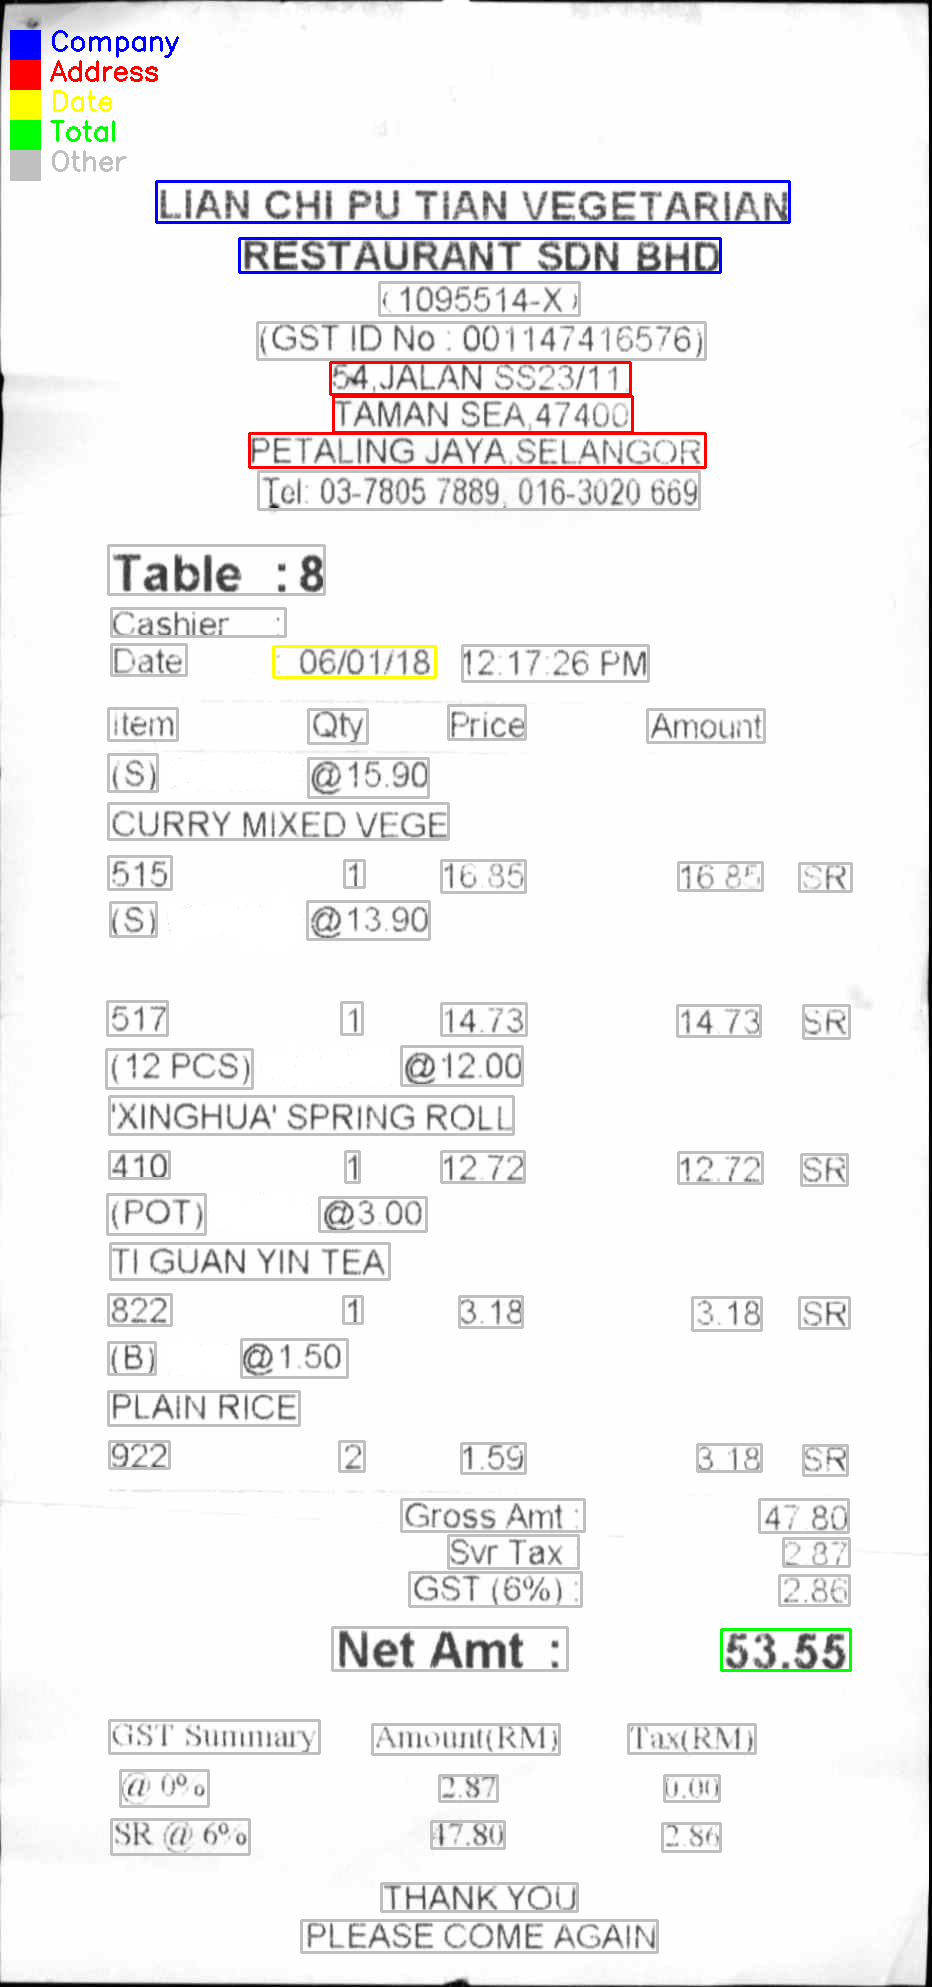

In [21]:
# Load the image
image_path = '/content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51005447848.jpg'
image = cv2.imread(image_path)

# Define colors for different entities
colors = {
    'company': (255, 0, 0),  # Blue
    'address': (0, 0, 255),  # Red
    'date': (0, 255, 255),   # Yellow
    'total': (0, 255, 0),    # Green
    'other': (192, 192, 192) # Grey
}

# Define function to draw boxes on the image
def draw_boxes(image, coordinates, color):
    if coordinates:
        # Check if the coordinates are a list of lists or a single list
        if isinstance(coordinates[0], list):
            # If coordinates is a list of lists
            for coord in coordinates:
                # Draw the rectangle using the correct indices
                cv2.rectangle(image, (coord[0], coord[1]), (coord[4], coord[5]), color, 2)
        else:
            # If coordinates is a single list
            cv2.rectangle(image, (coordinates[0], coordinates[1]), (coordinates[4], coordinates[5]), color, 2)

# Draw boxes for different entities on the image
draw_boxes(image, company_coordinates, colors['company'])
draw_boxes(image, address_coordinates, colors['address'])
draw_boxes(image, [date_coordinates], colors['date'])  # Note: date_coordinates should be a single coordinate pair
draw_boxes(image, [total_coordinates], colors['total'])  # Note: total_coordinates should be a single coordinate pair

# Draw grey boxes for other coordinates
draw_boxes(image, other_coordinates, colors['other'])

# Add a legend to the image
legend_texts = ['Company', 'Address', 'Date', 'Total', 'Other']
legend_colors = [colors['company'], colors['address'], colors['date'], colors['total'], colors['other']]
start_x, start_y = 50, 50
line_height = 30

for i, (text, color) in enumerate(zip(legend_texts, legend_colors)):
    cv2.putText(image, text, (start_x, start_y + i * line_height), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    cv2.rectangle(image, (start_x - 40, start_y - 20 + i * line_height), (start_x - 10, start_y + 10 + i * line_height), color, -1)

# Display the image with the legend
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [22]:
import os
import json
import cv2
from fuzzywuzzy import fuzz

# Load entities from JSON file
def load_entities(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Extract text from entities data
def extract_text(entities_data, key):
    return entities_data.get(key, "").strip("'")

# Define function to draw boxes on the image
def draw_boxes(image, coordinates, color, filename):
    if coordinates:
        if isinstance(coordinates[0], list):
            for coord in coordinates:
                if len(coord) >= 8:  # Check if coordinates have at least 8 elements
                    cv2.rectangle(image, (coord[0], coord[1]), (coord[4], coord[5]), color, 2)
                else:
                    print(f"Invalid coordinates in file: {filename}")
        else:
            if len(coordinates) >= 8:  # Check if coordinates have at least 8 elements
                cv2.rectangle(image, (coordinates[0], coordinates[1]), (coordinates[4], coordinates[5]), color, 2)
            else:
                print(f"Invalid coordinates in file: {filename}")

# Process each file
def process_file(box_file, entity_file, image_file):
    # Load entities
    entities_data = load_entities(entity_file)

    # Extract relevant text
    company_text = extract_text(entities_data, "company")
    address_text = extract_text(entities_data, "address")
    date_text = extract_text(entities_data, "date")
    total_text = extract_text(entities_data, "total")

    # Define variables to store coordinates
    company_coordinates = []
    address_coordinates = []
    date_coordinates = []
    total_coordinates = []
    other_coordinates = []

    # Loop through the lines in the box file
    with open(box_file, 'r') as f:
        box_lines = f.readlines()

    for line in box_lines:
        parts = line.strip().split(',')
        coordinates = list(map(int, parts[:8]))
        text = ",".join(parts[8:]).strip("'")

        # Fuzzy matching to identify entities
        if fuzz.token_set_ratio(text, company_text) >= 90:
            company_coordinates.append(coordinates)
        elif fuzz.token_set_ratio(text, address_text) >= 90:
            address_coordinates.append(coordinates)
        elif fuzz.token_set_ratio(text, date_text) >= 90:
            date_coordinates = coordinates
        elif fuzz.token_set_ratio(text, total_text) >= 90:
            total_coordinates = coordinates
        else:
            other_coordinates.append(coordinates)

    # Load the image
    image = cv2.imread(image_file)

    # Draw boxes for different entities
    draw_boxes(image, company_coordinates, colors['company'], image_file)
    draw_boxes(image, address_coordinates, colors['address'], image_file)
    draw_boxes(image, [date_coordinates], colors['date'], image_file)
    draw_boxes(image, [total_coordinates], colors['total'], image_file)
    draw_boxes(image, other_coordinates, colors['other'], image_file)

    # Save the annotated image
    output_path = os.path.join("/content/boxed_receipts", os.path.basename(image_file))
    cv2.imwrite(output_path, image)

# Define colors for different entities
colors = {
    'company': (255, 0, 0),  # Blue
    'address': (0, 0, 255),  # Red
    'date': (0, 255, 255),   # Yellow
    'total': (0, 255, 0),    # Green
    'other': (192, 192, 192) # Grey
}

# Create output directory if not exists
output_dir = "/content/boxed_receipts"
os.makedirs(output_dir, exist_ok=True)

# Process each file in the train directory
box_dir = "/content/drive/MyDrive/Dissertation/SROIE2019/train/box"
entity_dir = "/content/drive/MyDrive/Dissertation/SROIE2019/train/entities"
image_dir = "/content/drive/MyDrive/Dissertation/SROIE2019/train/img"

for box_file in os.listdir(box_dir):
    if box_file.endswith(".txt"):
        box_path = os.path.join(box_dir, box_file)
        entity_file = os.path.join(entity_dir, box_file)
        image_file = os.path.join(image_dir, box_file.replace(".txt", ".jpg"))

        if os.path.exists(entity_file) and os.path.exists(image_file):
            process_file(box_path, entity_file, image_file)


Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51005433522.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51005447850.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51006466060.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51006679216.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51007339106.jpg
Invalid coordinates in file: /content/drive/MyDrive/Dissertation/SROIE2019/train/img/X51008142038.jpg


In [23]:
import os
import pandas as pd
import json

# Directory paths
box_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/train/box/'
entity_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/'

# Initialize a list to store extracted data
extracted_data = []

# Step 1: Read Bounding Box Files
for box_file in os.listdir(box_files_dir):
    if box_file.endswith('.txt'):
        # Construct full file path
        box_file_path = os.path.join(box_files_dir, box_file)

        # Read bounding box file
        with open(box_file_path, 'r') as file:
            bounding_boxes = []
            for line in file:
                parts = line.strip().split(',')
                bbox = list(map(int, parts[:8]))
                text = parts[8]
                bounding_boxes.append({'bbox': bbox, 'text': text})

        # Step 2: Read corresponding entity file
        entity_file_path = os.path.join(entity_files_dir, box_file)
        if os.path.exists(entity_file_path):
            with open(entity_file_path, 'r') as file:
                entities = json.load(file)
                company_name = entities.get('company', '')

            # Step 3: Match Bounding Boxes with Company Names
            for bbox in bounding_boxes:
                if company_name in bbox['text']:
                    extracted_data.append({
                        'Filename': box_file[:-4],  # Remove the ".txt" extension
                        'Bounding Box Coordinates': bbox['bbox'],
                        'Company Name': company_name
                    })

# Step 4: Generate Excel File
# Convert list to DataFrame
df = pd.DataFrame(extracted_data)

# Save DataFrame to Excel
output_file = 'bounding_boxes_with_company_names.xlsx'
df.to_excel(output_file, index=False)

print(f'Excel file "{output_file}" created successfully.')


Excel file "bounding_boxes_with_company_names.xlsx" created successfully.


In [24]:
import os
import pandas as pd
import json

# Directory paths
box_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/train/box/'
entity_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/train/entities/'

# Initialize a list to store extracted data
extracted_data = []

# Step 1: Read Bounding Box Files
for box_file in os.listdir(box_files_dir):
    if box_file.endswith('.txt'):
        # Construct full file path
        box_file_path = os.path.join(box_files_dir, box_file)

        # Read bounding box file
        with open(box_file_path, 'r') as file:
            bounding_boxes = []
            for line in file:
                parts = line.strip().split(',')
                bbox = list(map(int, parts[:8]))
                bounding_boxes.append(bbox)

        # Step 2: Read corresponding entity file
        entity_file_path = os.path.join(entity_files_dir, box_file)
        if os.path.exists(entity_file_path):
            with open(entity_file_path, 'r') as file:
                entities = json.load(file)
                company_name = entities.get('company', '')

            # Step 3: Store all bounding boxes and the company name
            extracted_data.append({
                'Filename': box_file[:-4],  # Remove the ".txt" extension
                'Bounding Box Coordinates': bounding_boxes,
                'Company Name': company_name
            })

# Step 4: Generate Excel File
# Convert list to DataFrame
df = pd.DataFrame(extracted_data)

# Save DataFrame to Excel
output_file = 'bounding_boxes_with_company_names_train.xlsx'
df.to_excel(output_file, index=False)

print(f'Excel file "{output_file}" created successfully.')


Excel file "bounding_boxes_with_company_names_train.xlsx" created successfully.


In [ ]:
import os
import pandas as pd
import json

# Directory paths
box_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/test/box/'
entity_files_dir = '/content/drive/MyDrive/Dissertation/SROIE2019/test/entities/'

# Initialize a list to store extracted data
extracted_data = []

# Step 1: Read Bounding Box Files
for box_file in os.listdir(box_files_dir):
    if box_file.endswith('.txt'):
        # Construct full file path
        box_file_path = os.path.join(box_files_dir, box_file)

        # Read bounding box file
        with open(box_file_path, 'r', encoding='latin1', errors='ignore') as file:  # Specify encoding and error handling
            bounding_boxes = []
            for line in file:
                parts = line.strip().split(',')
                # Check if all parts are valid integers
                if len(parts) >= 8 and all(part.isdigit() for part in parts[:8]):
                    bbox = list(map(int, parts[:8]))
                    bounding_boxes.append(bbox)

        # Step 2: Read corresponding entity file
        entity_file_path = os.path.join(entity_files_dir, box_file)
        if os.path.exists(entity_file_path):
            with open(entity_file_path, 'r', encoding='latin1', errors='ignore') as file:  # Specify encoding and error handling
                entities = json.load(file)
                company_name = entities.get('company', '')

            # Step 3: Store all bounding boxes and the company name
            extracted_data.append({
                'Filename': box_file[:-4],  # Remove the ".txt" extension
                'Bounding Box Coordinates': bounding_boxes,
                'Company Name': company_name
            })

# Step 4: Generate Excel File
# Convert list to DataFrame
df = pd.DataFrame(extracted_data)

# Save DataFrame to Excel
output_file = 'bounding_boxes_with_company_names_test.xlsx'
df.to_excel(output_file, index=False)

print(f'Excel file "{output_file}" created successfully.')


Excel file "bounding_boxes_with_company_names_test.xlsx" created successfully.


Angle check- Train

In [38]:
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/bounding_boxes_with_company_names_train.xlsx'
data_train = pd.read_excel(file_path)

# Extract the bounding box coordinates
bounding_boxes_column = data_train['Bounding Box Coordinates']

bounding_boxes = []
for cell in bounding_boxes_column:
    if pd.notna(cell):  # Check if the cell is not NaN
        # Convert the cell string to a list of lists
        boxes = ast.literal_eval(cell)
        for box in boxes:
            bounding_boxes.append(box)

def calculate_orientation_angle(box):
    # Extract top-left and top-right corner coordinates
    x1, y1 = box[0], box[1]
    x2, y2 = box[2], box[3]

    # Calculate the angle of orientation
    angle = math.atan2(y2 - y1, x2 - x1) * 180 / math.pi
    return angle

angles = []
for box in bounding_boxes:
    angle = calculate_orientation_angle(box)
    if angle != 0:
        angles.append(angle)

# Print all non-zero angles
for angle in angles:
    print(f"Angle of orientation: {angle}")


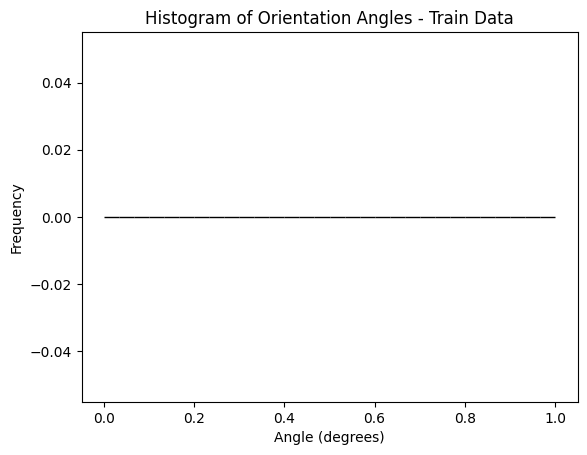

In [39]:
# Plot the histogram
plt.hist(angles, bins=30, edgecolor='black')
plt.title('Histogram of Orientation Angles - Train Data')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.show()


Angle check- Test

In [40]:
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/content/testonly.xlsx'
data_test = pd.read_excel(file_path)

# Extract the bounding box coordinates
bounding_boxes_column = data_test['Bounding Box Coordinates']

bounding_boxes = []
for cell in bounding_boxes_column:
    if pd.notna(cell):  # Check if the cell is not NaN
        # Convert the cell string to a list of lists
        boxes = ast.literal_eval(cell)
        for box in boxes:
            bounding_boxes.append(box)

def calculate_orientation_angle(box):
    # Extract top-left and top-right corner coordinates
    x1, y1 = box[0], box[1]
    x2, y2 = box[2], box[3]

    # Calculate the angle of orientation
    angle = math.atan2(y2 - y1, x2 - x1) * 180 / math.pi
    return angle

angles = []
for box in bounding_boxes:
    angle = calculate_orientation_angle(box)
    if angle != 0:
        angles.append(angle)

# Print all non-zero angles
for angle in angles:
    print(f"Angle of orientation: {angle}")


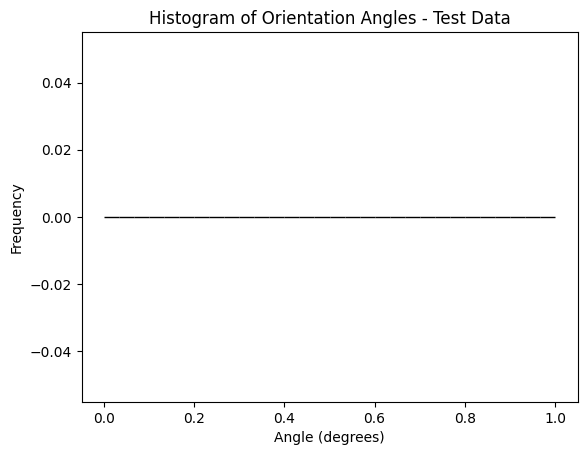

In [41]:
# Plot the histogram
plt.hist(angles, bins=30, edgecolor='black')
plt.title('Histogram of Orientation Angles - Test Data')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.show()

**BASELINE**

In [42]:
import pandas as pd

# Load the train and test Excel files
train_df = pd.read_excel('/content/bounding_boxes_with_company_names_train.xlsx')
test_df = pd.read_excel('/content/testonly.xlsx')

# Display the first few rows to understand the structure
print(train_df.head())
print(test_df.head())


       Filename                           Bounding Box Coordinates  \
0  X51005306399  [[68, 13, 95, 13, 95, 51, 68, 51], [43, 87, 35...   
1  X51005268400  [[72, 27, 680, 27, 680, 81, 72, 81], [165, 82,...   
2  X51005255805  [[130, 68, 676, 68, 676, 105, 130, 105], [325,...   
3  X51005361900  [[723, 557, 1451, 557, 1451, 618, 723, 618], [...   
4  X00016469623  [[83, 41, 331, 41, 331, 78, 83, 78], [109, 171...   

                  Company Name  
0     SHELL ISNI PETRO TRADING  
1        RESTORAN HASSANBISTRO  
2           SAM SAM TRADING CO  
3  TEO HENG STATIONERY & BOOKS  
4        MR D.I.Y. (M) SDN BHD  
       Filename                           Bounding Box Coordinates  \
0  X51005230616  [[244, 105, 327, 105, 327, 167, 244, 167], [37...   
1  X51005200931  [[380, 241, 616, 241, 616, 266, 380, 266], [45...   
2  X51005361908  [[780, 315, 1262, 315, 1262, 362, 780, 362], [...   
3  X51005268275  [[174, 227, 682, 227, 682, 271, 174, 271], [23...   
4  X51005361912  [[119, 260, 84

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix

def normalize_coordinates(coordinates):
    coords_array = np.array(coordinates)
    max_coords = np.max(coords_array, axis=0)
    normalized_coords = coords_array / max_coords
    return normalized_coords

def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

def create_sparse_matrix(normalized_coords, areas, centroids):
    row = []
    col = []
    data = []

    for i, (coord, area, centroid) in enumerate(zip(normalized_coords, areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(len(normalized_coords), 3))
    return sparse_matrix


In [ ]:
def pad_features(features, max_length):
    padded_features = []
    for feature in features:
        if len(feature) < max_length:
            padded_feature = np.pad(feature, (0, max_length - len(feature)), 'constant')
        else:
            padded_feature = feature[:max_length]
        padded_features.append(padded_feature)
    return np.array(padded_features)

def process_dataset(df, max_length):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        normalized_coords = normalize_coordinates(bounding_boxes)
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
        features.append(sparse_matrix.toarray().flatten())

    # Pad the features to ensure they have consistent length
    features = pad_features(features, max_length)
    return features, labels

# Determine the maximum length for padding based on the training dataset
max_length = train_df['Bounding Box Coordinates'].apply(lambda x: len(eval(x)) * 8).max()

# Process the train and test datasets
X_train, y_train = process_dataset(train_df, max_length)
X_test, y_test = process_dataset(test_df, max_length)


In [ ]:
max_length

1224

In [ ]:
X_train.shape

(626, 1224)

In [ ]:
X_train

array([[1.0260e+03, 8.1500e+01, 3.2000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.2832e+04, 3.7600e+02, 5.4000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0202e+04, 4.0300e+02, 8.6500e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.7360e+03, 7.5000e+01, 2.9000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.1852e+04, 3.9050e+02, 3.5900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.7545e+04, 3.8750e+02, 3.4850e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [ ]:
y_train

array(['SHELL ISNI PETRO TRADING', 'RESTORAN HASSANBISTRO',
       'SAM SAM TRADING CO', 'TEO HENG STATIONERY & BOOKS',
       'MR D.I.Y. (M) SDN BHD', 'SOON HUAT MACHINERY ENTERPRISE',
       'SYL ROASTED DELIGHTS SDN. BHD.', 'TEO HENG STATIONERY & BOOKS',
       'LIGHTROOM GALLERY SDN BHD', 'TED HENG STATIONERY & BOOKS',
       'INDAH GIFT & HOME DECO', 'FUYI MINI MARKET',
       'MR D.I.Y. (JOHOR) SDN BHD', 'GERBANG ALAF RESTAURANTS SDN BHD',
       'HOME MASTER HARDWARE & ELECTRICAL', 'TEO HENG STATIONERY & BOOKS',
       'ASIA MART', 'AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD',
       'LIGHTROOM GALLERY SDN BHD', 'YONGFATT ENTERPRISE',
       'LIGHTROOM GALLERY SDN BHD',
       'S.H.H. MOTOR (SUNGAI RENGIT) SDN. BHD.',
       'TEO HENG STATIONERY & BOOKS', 'BOOK TA .K (TAMAN DAYA) SDN BHD',
       'PERNIAGAAN ZHENG HUI', 'HOME MASTER HARDWARE & ELECTRICAL',
       'ABC HO TRADING', 'PERNIAGAAN ZHENG HUI', 'THREE STOOGES',
       'PASAR MINI JIN SENG', 'YHM AEON TEBRAU CITY

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 61.11%


In [ ]:
# Print predicted and actual company names
for actual, predicted in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Actual: GERBANG ALAF RESTAURANTS SDN BHD, Predicted: GERBANG ALAF RESTAURANTS SDN BHD
Actual: PERNIAGAAN ZHENG HUI, Predicted: PERNIAGAAN ZHENG HUI
Actual: TEO HENG STATIONERY & BOOKS, Predicted: CARREFOUR RESTAURANT
Actual: LIGHTROOM GALLERY SDN BHD, Predicted: LIGHTROOM GALLERY SDN BHD
Actual: TEO HENG STATIONERY & BOOKS, Predicted: SYARIKAT PERNIAGAAN GIN KEE
Actual: UROKO JAPANESE CUISINE SDN BHD, Predicted: GL HANDICRAFT & TAII ORING
Actual: SWC ENTERPRISE SDN BHD, Predicted: B & BEST RESTAURANT
Actual: PASAR MINI JIN SENG, Predicted: WARAKUYA PERMAS CITY SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: LIGHTROOM GALLERY SDN BHD, Predicted: LIGHTROOM GALLERY SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: YHM AEON TEBRAU CITY, Predicted: YHM AEON TEBRAU CITY
Actual: TRIPLE SIX POINT ENTERPRISE 666, Predicted: TRIPLE SIX POINT ENTERPRISE 666
Actual: TED HENG STATIONERY & BOOKS, Predic

In [ ]:
# Example new bounding boxes
def predict_company(new_bounding_boxes, clf, max_length):
    normalized_coords = normalize_coordinates(new_bounding_boxes)
    areas, centroids = calculate_area_and_centroid(new_bounding_boxes)
    sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
    features = sparse_matrix.toarray().flatten()
    features = pad_features([features], max_length)
    predicted_company = clf.predict(features)
    return predicted_company


new_bounding_boxes = [[244, 105, 327, 105, 327, 167, 244, 167], [37, 188, 477, 188, 477, 225, 37, 225], [192, 227, 310, 227, 310, 260, 192, 260], [136, 256, 366, 256, 366, 289, 136, 289], [27, 287, 480, 287, 480, 324, 27, 324], [103, 323, 419, 323, 419, 362, 103, 362], [4, 356, 529, 356, 529, 391, 4, 391], [2, 389, 533, 389, 533, 428, 2, 428], [205, 422, 313, 422, 313, 453, 205, 453], [101, 451, 434, 451, 434, 486, 101, 486], [23, 484, 505, 484, 505, 519, 23, 519], [112, 517, 418, 517, 418, 550, 112, 550], [188, 552, 345, 552, 345, 583, 188, 583], [194, 616, 347, 616, 347, 653, 194, 653], [4, 680, 277, 680, 277, 721, 4, 721], [4, 715, 502, 715, 502, 752, 4, 752], [4, 751, 118, 751, 118, 782, 4, 782], [29, 782, 240, 782, 240, 813, 29, 813], [50, 819, 166, 819, 166, 850, 50, 850], [52, 848, 191, 848, 191, 887, 52, 887], [31, 881, 238, 881, 238, 914, 31, 914], [54, 914, 168, 914, 168, 945, 54, 945], [56, 949, 186, 949, 186, 976, 56, 976], [27, 980, 205, 980, 205, 1015, 27, 1015], [5, 1048, 321, 1048, 321, 1080, 5, 1080], [5, 1082, 183, 1082, 183, 1111, 5, 1111], [2, 1110, 190, 1110, 190, 1143, 2, 1143], [5, 1148, 90, 1148, 90, 1179, 5, 1179], [8, 1212, 285, 1212, 285, 1249, 8, 1249], [455, 751, 527, 751, 527, 784, 455, 784], [455, 788, 525, 788, 525, 817, 455, 817], [459, 881, 529, 881, 529, 916, 459, 916], [467, 982, 533, 982, 533, 1015, 467, 1015], [451, 1048, 525, 1048, 525, 1079, 451, 1079], [451, 1084, 528, 1084, 528, 1113, 451, 1113], [447, 1112, 528, 1112, 528, 1143, 447, 1143], [455, 1150, 527, 1150, 527, 1177, 455, 1177], [465, 1214, 527, 1214, 527, 1245, 465, 1245], [108, 1307, 476, 1307, 476, 1342, 108, 1342], [66, 1375, 451, 1375, 451, 1406, 66, 1406], [238, 1408, 279, 1408, 279, 1439, 238, 1439], [66, 1443, 465, 1443, 465, 1478, 66, 1478], [116, 1476, 416, 1476, 416, 1511, 116, 1511], [93, 1541, 422, 1541, 422, 1578, 93, 1578], [27, 1600, 457, 1600, 457, 1637, 27, 1637], [19, 1644, 532, 1644, 532, 1677, 19, 1677]]

predicted_company = predict_company(new_bounding_boxes, clf, max_length)
print(predicted_company)

['GERBANG ALAF RESTAURANTS SDN BHD']


In [ ]:
def predict_company(new_bounding_boxes, clf, max_length):
    normalized_coords = normalize_coordinates(new_bounding_boxes)
    areas, centroids = calculate_area_and_centroid(new_bounding_boxes)
    sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
    features = sparse_matrix.toarray().flatten()
    features = pad_features([features], max_length)
    predicted_company = clf.predict(features)
    return predicted_company

def predict_and_print(new_bounding_boxes, actual_company, clf, max_length):
    predicted_company = predict_company(new_bounding_boxes, clf, max_length)
    print("Bounding Box Coordinates:")
    for bbox in new_bounding_boxes:
        print(bbox)
    print(f"Actual Company: {actual_company}")
    print(f"Predicted Company: {predicted_company[0]}")

predict_and_print(new_bounding_boxes, "Actual Company Name", clf, max_length)


Bounding Box Coordinates:
[244, 105, 327, 105, 327, 167, 244, 167]
[37, 188, 477, 188, 477, 225, 37, 225]
[192, 227, 310, 227, 310, 260, 192, 260]
[136, 256, 366, 256, 366, 289, 136, 289]
[27, 287, 480, 287, 480, 324, 27, 324]
[103, 323, 419, 323, 419, 362, 103, 362]
[4, 356, 529, 356, 529, 391, 4, 391]
[2, 389, 533, 389, 533, 428, 2, 428]
[205, 422, 313, 422, 313, 453, 205, 453]
[101, 451, 434, 451, 434, 486, 101, 486]
[23, 484, 505, 484, 505, 519, 23, 519]
[112, 517, 418, 517, 418, 550, 112, 550]
[188, 552, 345, 552, 345, 583, 188, 583]
[194, 616, 347, 616, 347, 653, 194, 653]
[4, 680, 277, 680, 277, 721, 4, 721]
[4, 715, 502, 715, 502, 752, 4, 752]
[4, 751, 118, 751, 118, 782, 4, 782]
[29, 782, 240, 782, 240, 813, 29, 813]
[50, 819, 166, 819, 166, 850, 50, 850]
[52, 848, 191, 848, 191, 887, 52, 887]
[31, 881, 238, 881, 238, 914, 31, 914]
[54, 914, 168, 914, 168, 945, 54, 945]
[56, 949, 186, 949, 186, 976, 56, 976]
[27, 980, 205, 980, 205, 1015, 27, 1015]
[5, 1048, 321, 1048, 321, 10

In [ ]:
def predict_company(test_df, index, clf, max_length):
    bounding_boxes = eval(test_df.iloc[index]['Bounding Box Coordinates'])
    actual_company = test_df.iloc[index]['Company Name']

    normalized_coords = normalize_coordinates(bounding_boxes)
    areas, centroids = calculate_area_and_centroid(bounding_boxes)
    sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
    features = sparse_matrix.toarray().flatten()
    features = pad_features([features], max_length)
    predicted_company = clf.predict(features)

    # print("Bounding Box Coordinates:")
    # for idx, bbox in enumerate(bounding_boxes):
    #     print(f"Index: {idx}, Bounding Box: {bbox}")
    print(f"Actual Company: {actual_company}")
    # print(f"Predicted Company: {predicted_company[0]}")
    return predicted_company

# Choose an index from the test dataframe to make predictions on
index = 45  # You can change this index as needed

predicted_company = predict_company(test_df, index, clf, max_length)
print("Predicted Company")
print(predicted_company)


Actual Company: PASARAYA BORONG PINTAR SDN BHD
Predicted Company
['BEMED (SP) SDN. BHD.']


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate the KNN model on the test set
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn * 100:.2f}%")

# # Define a function to predict using KNN
# def predict_company_knn(test_df, index, knn, max_length):
#     bounding_boxes = eval(test_df.iloc[index]['Bounding Box Coordinates'])
#     actual_company = test_df.iloc[index]['Company Name']

#     normalized_coords = normalize_coordinates(bounding_boxes)
#     areas, centroids = calculate_area_and_centroid(bounding_boxes)
#     sparse_matrix = create_sparse_matrix(normalized_coords, areas, centroids)
#     features = sparse_matrix.toarray().flatten()
#     features = pad_features([features], max_length)
#     predicted_company = knn.predict(features)

#     print("Bounding Box Coordinates:")
#     for idx, bbox in enumerate(bounding_boxes):
#         print(f"Index: {idx}, Bounding Box: {bbox}")
#     print(f"Actual Company: {actual_company}")
#     print(f"Predicted Company (KNN): {predicted_company[0]}")
#     return predicted_company

# # Choose an index from the test dataframe to make predictions on
# index = 0  # You can change this index as needed

# predicted_company_knn = predict_company_knn(test_df, index, knn, max_length)
# print(predicted_company_knn)


Test Accuracy (KNN): 51.59%


Baseline- No normalisation

In [44]:
import numpy as np
from scipy.sparse import coo_matrix
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def calculate_area_and_centroid(coordinates):
    areas = []
    centroids = []
    for box in coordinates:
        x0, y0, x1, y1, x2, y2, x3, y3 = box
        area = (x2 - x0) * (y2 - y0)
        centroid_x = (x0 + x2) / 2
        centroid_y = (y0 + y2) / 2
        areas.append(area)
        centroids.append((centroid_x, centroid_y))
    return areas, centroids

def create_sparse_matrix(coords, areas, centroids):
    row = []
    col = []
    data = []

    for i, (coord, area, centroid) in enumerate(zip(coords, areas, centroids)):
        row.extend([i] * 3)
        col.extend([0, 1, 2])
        data.extend([area, centroid[0], centroid[1]])

    sparse_matrix = coo_matrix((data, (row, col)), shape=(len(coords), 3))
    return sparse_matrix

def pad_features(features, max_length):
    padded_features = []
    for feature in features:
        if len(feature) < max_length:
            padded_feature = np.pad(feature, (0, max_length - len(feature)), 'constant')
        else:
            padded_feature = feature[:max_length]
        padded_features.append(padded_feature)
    return np.array(padded_features)

def process_dataset(df, max_length):
    features = []
    labels = df['Company Name'].values

    for index, row in df.iterrows():
        bounding_boxes = eval(row['Bounding Box Coordinates'])
        areas, centroids = calculate_area_and_centroid(bounding_boxes)
        sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids)  # Use bounding_boxes directly
        features.append(sparse_matrix.toarray().flatten())

    # Pad the features to ensure they have consistent length
    features = pad_features(features, max_length)
    return features, labels


# Determine the maximum length for padding based on the training dataset
max_length = train_df['Bounding Box Coordinates'].apply(lambda x: len(eval(x)) * 3).max()

# Process the train and test datasets
X_train, y_train = process_dataset(train_df, max_length)
X_test, y_test = process_dataset(test_df, max_length)

# Train the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 61.11%


In [45]:
X_train.shape

(626, 459)

In [47]:
y_train.shape

(626,)

In [48]:
# Print predicted and actual company names
for actual, predicted in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Actual: GERBANG ALAF RESTAURANTS SDN BHD, Predicted: GERBANG ALAF RESTAURANTS SDN BHD
Actual: PERNIAGAAN ZHENG HUI, Predicted: PERNIAGAAN ZHENG HUI
Actual: TEO HENG STATIONERY & BOOKS, Predicted: CARREFOUR RESTAURANT
Actual: LIGHTROOM GALLERY SDN BHD, Predicted: LIGHTROOM GALLERY SDN BHD
Actual: TEO HENG STATIONERY & BOOKS, Predicted: SYARIKAT PERNIAGAAN GIN KEE
Actual: UROKO JAPANESE CUISINE SDN BHD, Predicted: GL HANDICRAFT & TAII ORING
Actual: SWC ENTERPRISE SDN BHD, Predicted: B & BEST RESTAURANT
Actual: PASAR MINI JIN SENG, Predicted: WARAKUYA PERMAS CITY SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: LIGHTROOM GALLERY SDN BHD, Predicted: LIGHTROOM GALLERY SDN BHD
Actual: UNIHAKKA INTERNATIONAL SDN BHD, Predicted: UNIHAKKA INTERNATIONAL SDN BHD
Actual: YHM AEON TEBRAU CITY, Predicted: YHM AEON TEBRAU CITY
Actual: TRIPLE SIX POINT ENTERPRISE 666, Predicted: TRIPLE SIX POINT ENTERPRISE 666
Actual: TED HENG STATIONERY & BOOKS, Predic

In [55]:
def predict_company(test_df, index, clf, max_length):
    bounding_boxes = eval(test_df.iloc[index]['Bounding Box Coordinates'])
    actual_company = test_df.iloc[index]['Company Name']

    areas, centroids = calculate_area_and_centroid(bounding_boxes)
    sparse_matrix = create_sparse_matrix(bounding_boxes, areas, centroids)  # Use bounding_boxes directly
    features = sparse_matrix.toarray().flatten()
    features = pad_features([features], max_length)
    predicted_company = clf.predict(features)

    print(f"Actual Company: {actual_company}")
    return predicted_company

# Choose an index from the test dataframe to make predictions on
index = 45  # You can change this index as needed

predicted_company = predict_company(test_df, index, clf, max_length)
print("Predicted Company:")
print(predicted_company)

Actual Company: RESTORAN WAN SHENG
Predicted Company:
['RESTORAN WAN SHENG']


In [61]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have actual labels in 'actual_labels' and predicted labels in 'predicted_labels'
actual_labels = y_test
predicted_labels = y_pred

# Generate and print the classification report
print("Classification Report:")
print(classification_report(actual_labels, predicted_labels))

# Generate and print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(actual_labels, predicted_labels))


Classification Report:
                                                   precision    recall  f1-score   support

               32 PUB & BISTRO OWN BY CNU TRADING       0.00      0.00      0.00         0
                                99 SPEED MART S/B       0.67      0.77      0.71        13
                                   ABC HO TRADING       0.00      0.00      0.00         0
                                 AEON CO. (M) BHD       0.31      0.50      0.38         8
                                AEON CO. (M) BHD.       0.00      0.00      0.00         0
                             AEON CO. (M) SDN BHD       0.00      0.00      0.00         1
AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD       0.50      1.00      0.67         1
                           AMANO MALAYSIA SDN BHD       0.50      0.50      0.50         2
            AMPANG 210 FIRST CITY PARKING SDN BHD       0.00      0.00      0.00         0
               ANEKA INTERTRADE MARKETING SDN BHD       0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [66]:
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 0  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


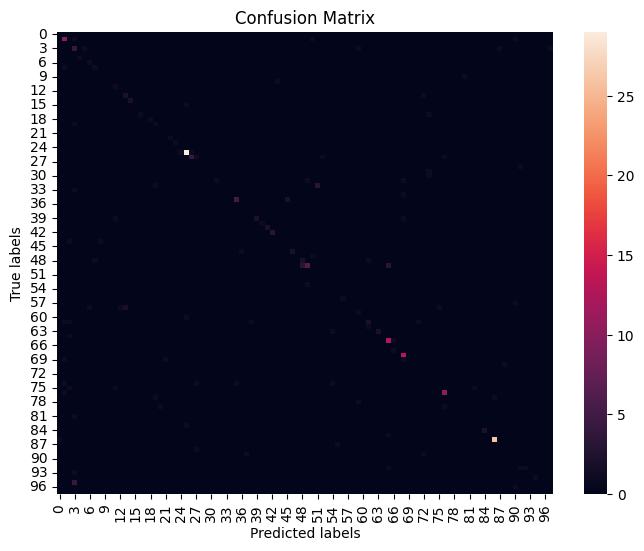

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you already have your confusion matrix stored in conf_matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
